# Covid19 Predictions

### Goal
We want to do a model fit on current data on the Covid19 Coronavirus to most accurately determine the future of this virus. If this is accurate, it could lead to better current decisions and precautions.

### Part 1: Fetching the data
The first part of this project is simply fetching the current data. On Github there is a self-updating JSON file with data collected by Johns Hopkins University's Center for Systems Science and Engineering (JHU CSSE), showing the number of deaths, cases, and recoveries by country for every date since January 22, 2020. Links can be found below:

* https://github.com/CSSEGISandData/COVID-19
* https://github.com/pomber/covid19

In [1]:
import requests

r = requests.get('https://pomber.github.io/covid19/timeseries.json')
json_data = r.json()

#This should print the number of confirmed cases in Thailand in January 22, 2020 
print(json_data['Thailand'][0]['confirmed'])

2


### Part 2: Worldwide Logistic Curve Fit
So rather than starting by focusing on the worldwide number of active cases, given by subtracting the number of deaths and recoveries from the confirmed cases. Basically, if you are alive and currently infected with coronavirus, you are an active case.

The numbers over time can then experience a logistic curve fit through a linear least squares system, thus giving us a rough estimate of a worldwide carrying capacity for the virus.

The first step is to get the scatterplot of worldwide cases over time:

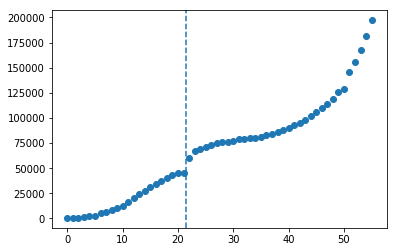

In [2]:
import matplotlib.pyplot as plt
import matplotlib.axes as axis

def worldwide(date_index):
    total = 0
    for key in json_data:
        total = total + json_data[key][date_index]['confirmed']
    return total

worldwide_data = []
for i in range(len(json_data['China'])):
    worldwide_data.append(worldwide(i))

plt.scatter(range(len(json_data['China'])), worldwide_data)
plt.axvline(x = 21.5, linestyle = '--')
plt.show()

However, here we have an interesting graph. It appears that this coronavirus had already experienced a wane and plateau. This means that the virus would have died out around 21 days after January 22, where the dashed line is.

This jump is best explained by the outbreak in Italy in early-mid February, which means that the first logistic progression could have been in a localized scale, where as the continuing progression is after a globalized scale has been reached.

To make sure that this is true, let us subtract Italy out of the curve, and isolate it to see if any ends meet:

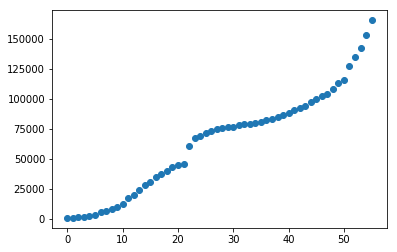

In [3]:
import matplotlib.pyplot as plt
import matplotlib.axes as axis

def worldwide_minus_italy(date_index):
    total = 0
    for key in json_data:
        if (key != 'Italy'):
            total = total + json_data[key][date_index]['confirmed']
    return total

worldwide_minus_italy_data = []
for i in range(len(json_data['China'])):
    worldwide_minus_italy_data.append(worldwide_minus_italy(i))

plt.scatter(range(len(json_data['China'])), worldwide_minus_italy_data)
plt.show()

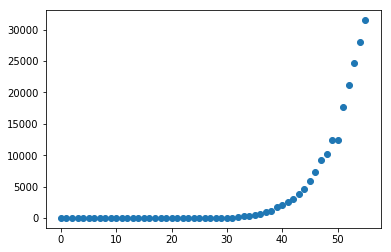

In [4]:
def italy(date_index):
    return json_data['Italy'][date_index]['confirmed']

italy_data = []
for i in range(len(json_data['China'])):
    italy_data.append(italy(i))

plt.scatter(range(len(json_data['China'])), italy_data)
plt.show()

So.., it appears that Italy isn't the source of the jump. Lets loop through and see which country has the highest difference between day 21 and 22, and plot the curve for that country.

In [5]:
max_difference = 0
jump_country = ''

for key in json_data:
    if (json_data[key][22]['confirmed'] - json_data[key][21]['confirmed'] > max_difference):
        max_difference = json_data[key][22]['confirmed'] - json_data[key][21]['confirmed']
        jump_country = key

print(jump_country)

China


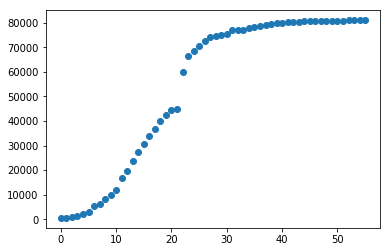

In [6]:
def china(date_index):
    return json_data['China'][date_index]['confirmed']

china_data = []
for i in range(len(json_data['China'])):
    china_data.append(china(i))

plt.scatter(range(len(json_data['China'])), china_data)
plt.show()

So it turns out, the source of the jump is in China! The benefit here of subtracting china out, is that they are already reaching their carrying capacity. So to put this in the worst way possible, the Coronavirus has become the rest of the world's problem. Lets then see what the curve looks like if we focus only outside mainland China:

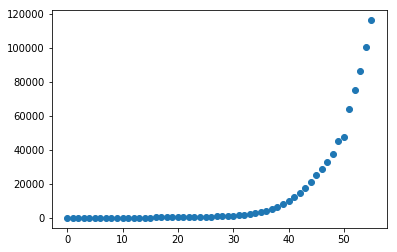

In [7]:
def outside_mainland_china(date_index):
    total = 0
    for key in json_data:
        if (key != 'China'):
            total = total + json_data[key][date_index]['confirmed']
    return total

outside_mainland_china_data = []
for i in range(len(json_data['China'])):
    outside_mainland_china_data.append(outside_mainland_china(i))

plt.scatter(range(len(json_data['China'])), outside_mainland_china_data)
plt.show()

So it looks like when we subtract China, the growth pattern is much smoother. This allows for a single logistic curve fit. To calculate the constant of proportionality and the carrying capacity, we'll do a linear least squares fit on a set of derivatives calculated through minimum finite difference.

Reciprocal Condition Number: 1.2212453270876722e-14


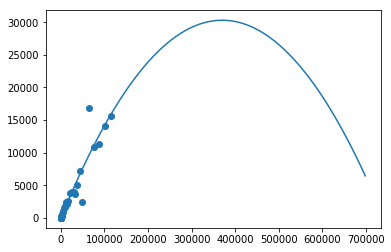

In [25]:
import numpy as np
import numpy.linalg as la

derivs = []
for i in range(1, len(outside_mainland_china_data)):
    derivs.append(outside_mainland_china_data[i]-outside_mainland_china_data[i - 1])
derivs = np.array(derivs)

polyfit = np.polyfit(outside_mainland_china_data[1:], derivs, 2)
p = np.poly1d(polyfit)

fit_data = []
for i in range(0, 700000, 1000):
    fit_data.append(p(i))

plt.scatter(outside_mainland_china_data[1:], derivs)
plt.plot(range(0, 700000, 1000), fit_data)
print("Reciprocal Condition Number: " + str(np.polyfit(outside_mainland_china_data[1:], derivs, 2, full=True)[4]))

So this is a graph with a parabolic fit of rate of increase in cases vs the total number of cases. Since coefficients of the logistic curve differential equation are given as follows, we can algebraicly determine the constant of proportionality as well as the carrying capacity.

$\frac{dy}{dx}=-\frac{ky^2}{L}+ky$

In [15]:
const_proportionality = polyfit[1]
carrying_capacity = polyfit[1]/polyfit[0]*(-1)

print("Carrying Capacity: " + str(carrying_capacity))
print("Constant of Proportionality " + str(const_proportionality))

Carrying Capacity: 740788.2916829472
Constant of Proportionality 0.16375273979356705


What we gather from this is that the carrying capacity for the number of cases of COVID19 outside of China lies at roughly 750,000. To get a progression of the virus over time, we turn to the general solution to the differential equation above:

$y=\frac{L}{1+be^{-kt}}$

This means that the only coefficient there is left to determine is $b$, our initial constant. To find this constant, we go through yet another round of least squares. Let $s=e^{-kt}$. Then,

$\frac{L}{1+bs}=y$

Meaning,

$\frac{bs}{L}=\frac{1}{y}-\frac{1}{L}$

So if we let $r=\frac{s}{L}=\frac{e^{-kt}}{L}$ and $p=\frac{1}{y}-\frac{1}{L}$, we are left with the system,

$b\vec{r}=\vec{p}$

Where $\vec{r},\vec{p}$ are known vectors, and $b$ is our desired scalar.

In [33]:
r = []
p = []
ratio_rp = []

for t in range(len(json_data['China'])):
    r.append(np.exp(-1*const_proportionality*t)/carrying_capacity)
    p.append(1/outside_mainland_china_data[t]-1/carrying_capacity)

for i in range(len(r)):
    ratio_rp.append(p[i]/r[i])

b = np.polyfit(range(len(json_data['China'])), ratio_rp, 0)
b = b[0]

print(b)

51003.26991191069


Since all the needed coefficients and constants are computed, a logistic function can be composed to predict the future of COVID19 outside of China.

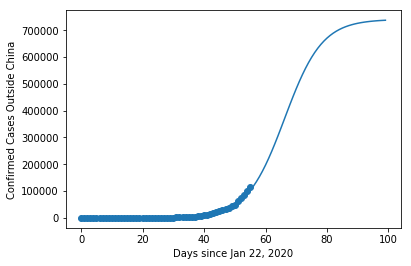

R Squared: 0.9842089665272848


In [40]:
def logistic(t):
    return carrying_capacity/(1+b*np.exp(-1 * const_proportionality * t))

logistic_curvefit = []
for t in range(100):
    logistic_curvefit.append(logistic(t))

fig, ax = plt.subplots()
ax.scatter(range(len(json_data['China'])), outside_mainland_china_data)
ax.plot(range(100), logistic_curvefit)
ax.set_xlabel('Days since Jan 22, 2020')
ax.set_ylabel('Confirmed Cases Outside China')
plt.show()

def r_squared():
    mean = np.mean(outside_mainland_china_data)
    err_from_curve = []
    err_from_mean = []
    for i in range(len(outside_mainland_china_data)):
        err_from_mean.append((outside_mainland_china_data[i] - mean)**2)
        err_from_curve.append((outside_mainland_china_data[i] - logistic_curvefit[i])**2) 
    return 1 - (sum(err_from_curve)/sum(err_from_mean))

print("R Squared: " + str(r_squared()))